## Change Detector in 4D tomography  

The goal of this notebook to build and test a "change detector" that returns coordinates of ROI(s) inside a 3D volume where morphology changes w.r.t the previous 3D image. To measure this change, a sub-volume (or patch) at time-step = t and the same patch from time-step = t-1 is passed through a latent feature extractor, then the Euclidean distance between the latent embeddings is computed as the "change metric". An array of this metric computed for different patches is then sorted to find the top 'n' patches that changed. Then this is visualized in a point cloud.  
Two reconstructions at time-steps 0 and 25, where tstep is defined as one full rotation (360) are compared here.  
**Data:** Coal-ice experiment data from Viktor Nikitin (APS 2-BM).  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from ct_segnet import viewer
# from features3D import FeatureExtractor4D
from tomo_encoders.patches import Patches
import tensorflow as tf
from tomo_encoders.neural_nets.porosity_encoders import build_CAE_3D
sys.path.append('../.')
from recon4D import DataGetter
import time
from feature_detection import SelfSupervisedCAE
from vis_utils import *

In [2]:
# Reconstruction stuff
fnames = ['/data02/MyArchive/coalice/melting_086.h5', \
          '/data02/MyArchive/coalice/flat_fields_melting_086.h5', \
          '/data02/MyArchive/coalice/dark_fields_melting_086.h5']
ntheta = 361 # these many projections per 180 degree spin
recon_params = {"mask_ratio" : None, \
                "contrast_s" : 0.01}

In [3]:
idxs = [0, 720*25]
dget = DataGetter(*fnames, ntheta)
vols = [dget.reconstruct_window(idx,dget.find_center(idx), **recon_params) for idx in idxs]
# fig, ax = plt.subplots(1,3, figsize = (14,6))
# viewer.view_midplanes(vol = vol, ax = ax)   

Shape of projection image: (1, 600, 960)
center = 471.00
center = 471.00


## Train auto-encoder for embedding  

In [4]:
# Feature Extraction stuff
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/coalice'

model_size = (64,64,64)
model_params = {"n_filters" : [16, 32, 64],\
                "n_blocks" : 3,\
                "activation" : 'lrelu',\
                "batch_norm" : True,\
                "hidden_units" : [128, 128],\
                "isconcat" : [True, True, True],\
                "pool_size" : [2,2,2],\
                "stdinput" : False}

# model_size = (64,64,64)
# model_params = {"n_filters" : [32, 64, 128],\
#                 "n_blocks" : 3,\
#                 "activation" : 'lrelu',\
#                 "batch_norm" : True,\
#                 "hidden_units" : [128, 32],\
#                 "isconcat" : [True, True, True],\
#                 "pool_size" : [2,2,2],\
#                 "stdinput" : False}

training_params = {"sampling_method" : "random-fixed-width", \
                   "batch_size" : 24, \
                   "n_epochs" : 5,\
                   "random_rotate" : True, \
                   "add_noise" : 0.15, \
                   "max_stride" : 1}
descriptor_tag = 'coal-ice-tzero-bin1'

In [5]:
fe = SelfSupervisedCAE(vols[0].shape, model_initialization = 'define-new', \
                         model_size = model_size, \
                         descriptor_tag = descriptor_tag, \
                         **model_params)

In [6]:
fe.train(vols[0], training_params["batch_size"], \
                            training_params["sampling_method"], \
                            training_params["n_epochs"],\
                            max_stride = training_params["max_stride"], \
                            random_rotate = training_params["random_rotate"], \
                            add_noise = training_params["add_noise"])

Epoch 1/5
16/16 [==============================] - 24s 997ms/step - loss: 0.0160
Epoch 2/5
16/16 [==============================] - 16s 1s/step - loss: 0.0049
Epoch 3/5
16/16 [==============================] - 16s 1s/step - loss: 0.0035
Epoch 4/5
16/16 [==============================] - 16s 1s/step - loss: 0.0032
Epoch 5/5
16/16 [==============================] - 16s 1s/step - loss: 0.0031
training time = 89.70 seconds


In [7]:
fe.save_models(model_path)

## Test it  

In [8]:
bin_tag = 'bin1'
bin_size = (64,64,64)
model_names = {"CAE" : "CAE_111d128_coal-ice-tzero-%s"%bin_tag, \
               "latent_embedder" : "latent_embedder_111d128_coal-ice-tzero-%s"%bin_tag}
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/coalice'

fe = SelfSupervisedCAE(vols[0].shape, \
                         model_initialization = 'load-model', \
                         model_names = model_names, model_path = model_path)

In [9]:
vols = [fe._normalize_volume(vol) for vol in vols]

total time for change detector = 21.48 seconds


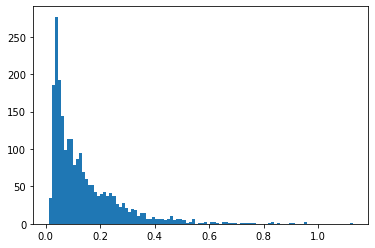

In [10]:
p = Patches(vols[0].shape, initialize_by = "grid", patch_size = bin_size)
p = fe.detect_changes(vols[0], vols[1], p)
h = plt.hist(p.features[:,0], bins = 100)

### Visualize the top 10 most changing regions  

**with embedding**

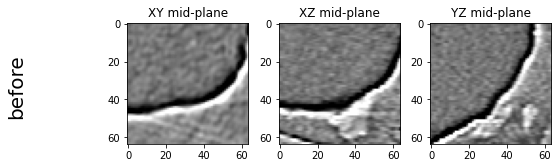

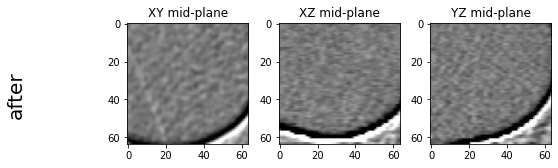

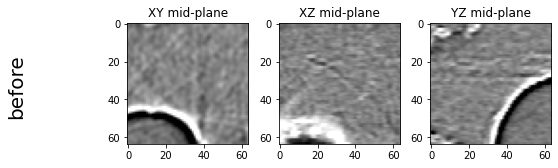

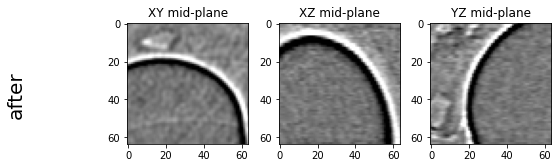

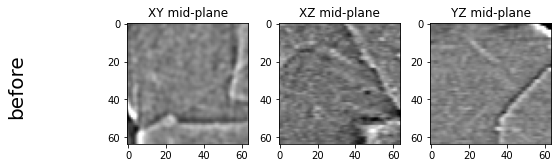

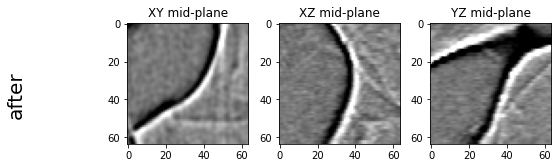

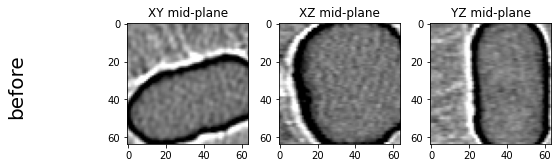

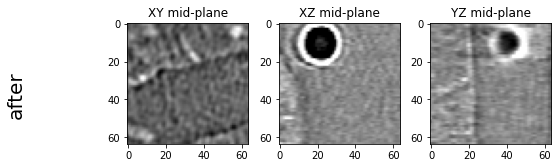

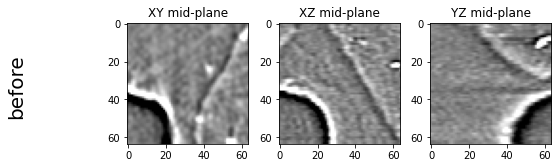

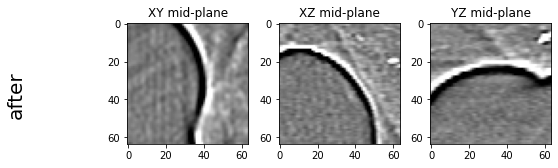

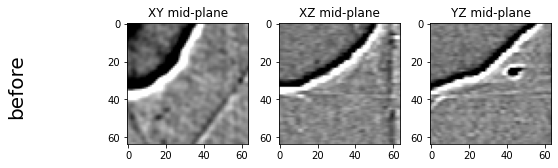

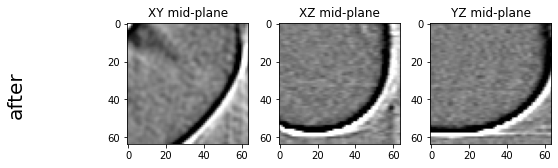

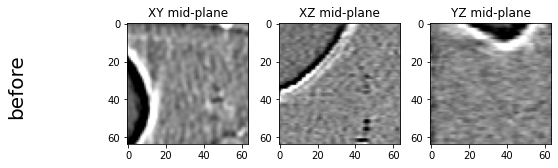

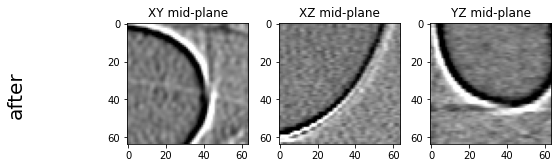

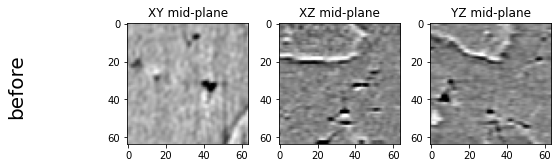

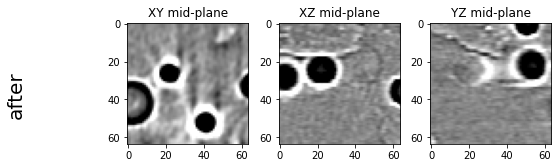

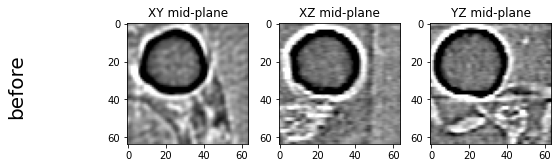

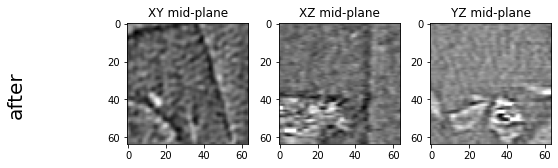

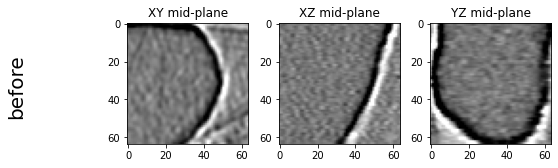

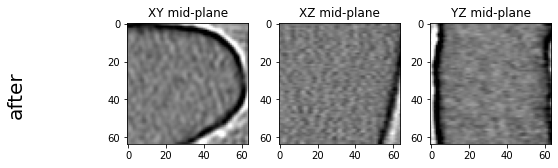

In [11]:
ife = 0
sel_type = "highest"
p_sel = p.select_by_feature(10, ife = ife, selection_by = sel_type)
for ii in range(10):
    show_before_after(vols, p_sel, ii)

**with pixel-mse**

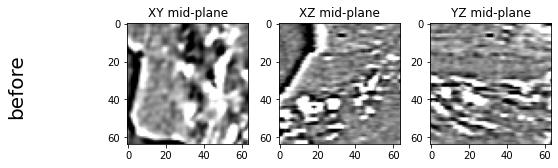

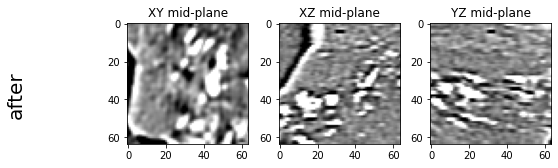

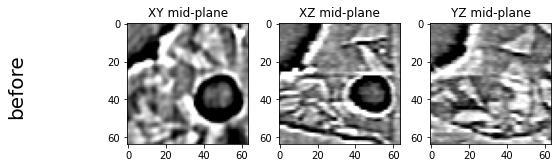

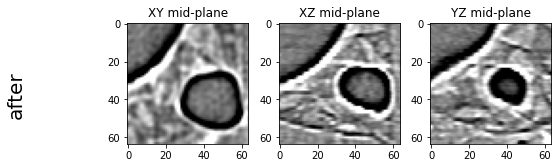

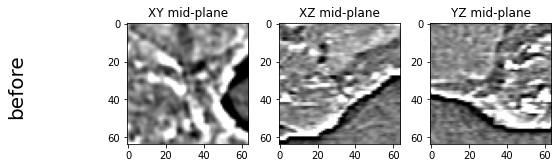

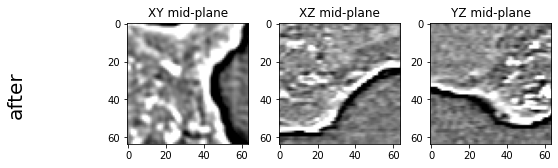

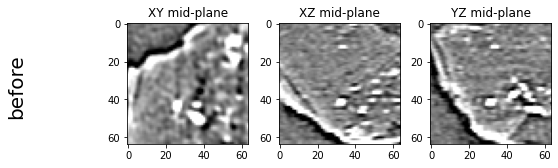

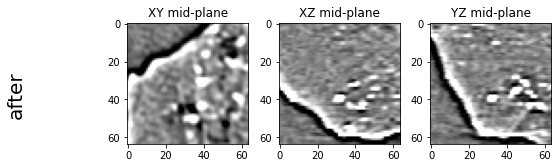

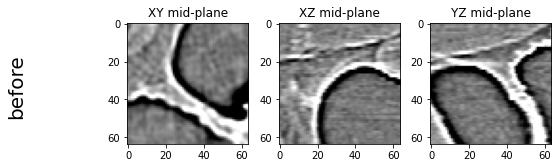

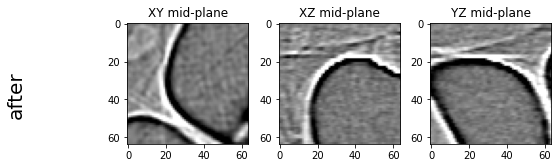

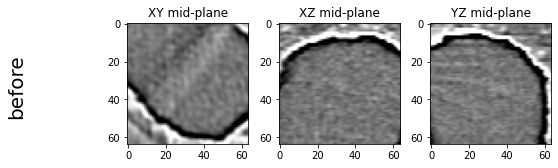

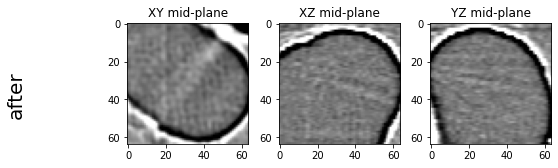

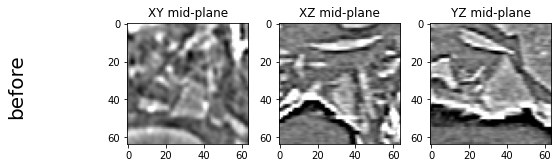

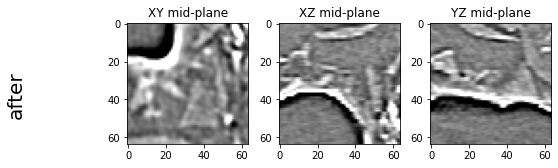

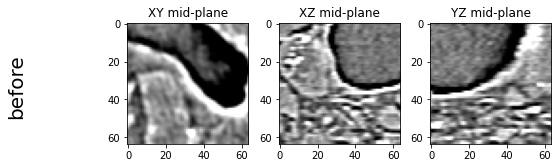

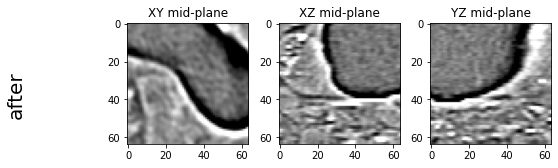

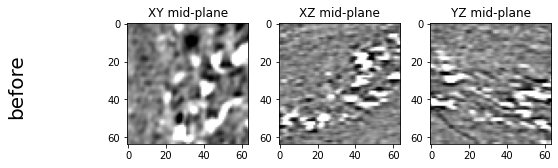

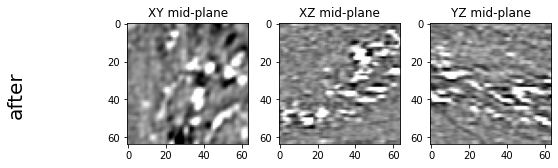

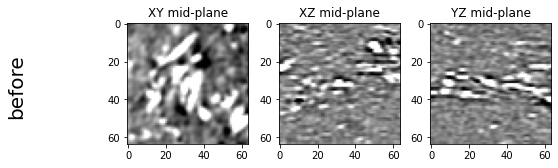

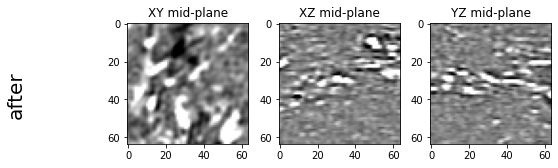

In [12]:
ife = 1
sel_type = "highest"
p_sel = p.select_by_feature(10, ife = ife, selection_by = sel_type)
for ii in range(10):
    show_before_after(vols, p_sel, ii)

### Visualize the 10 least changing regions  

**with embedding**

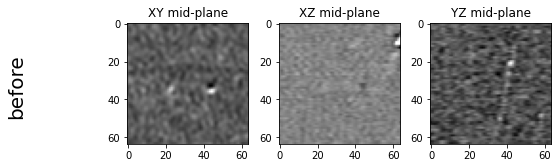

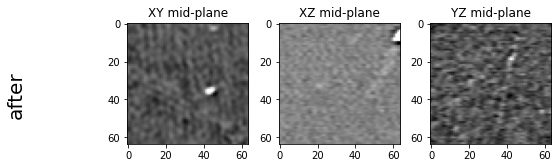

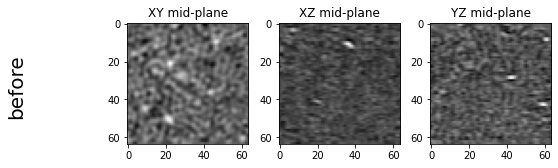

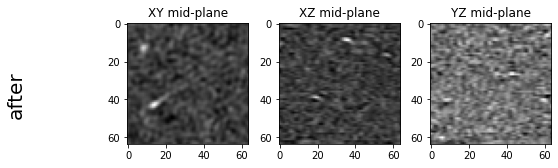

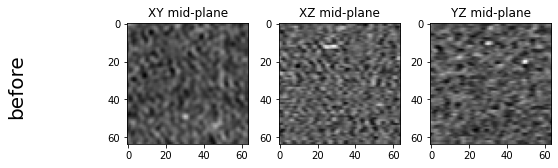

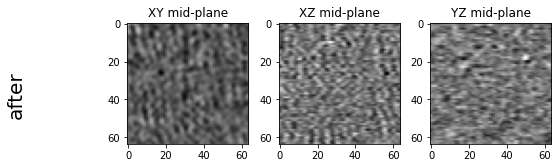

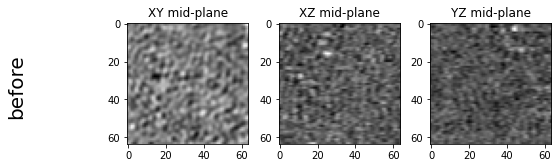

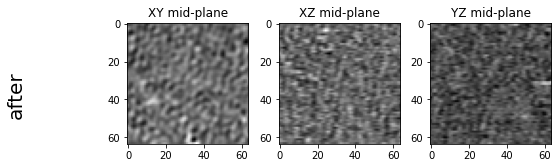

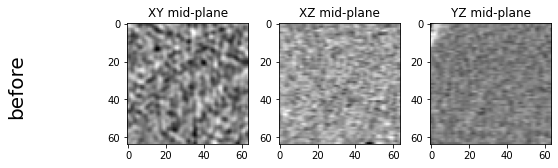

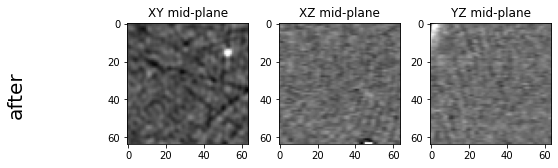

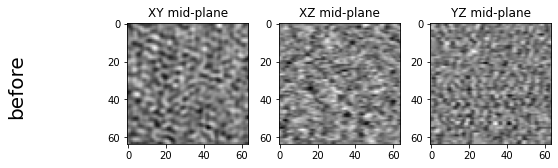

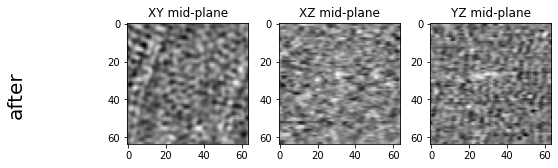

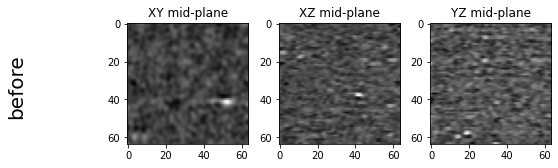

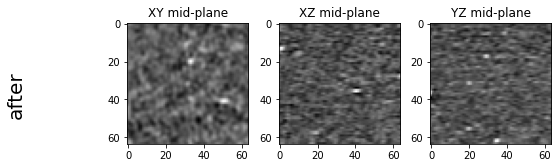

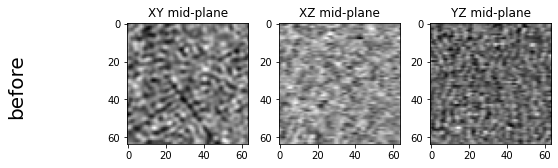

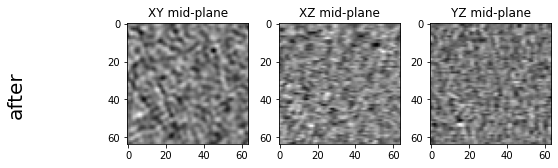

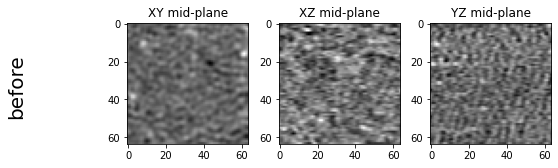

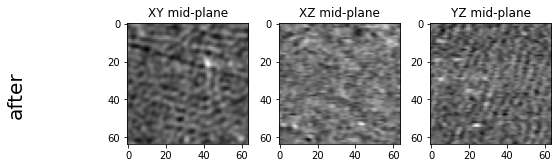

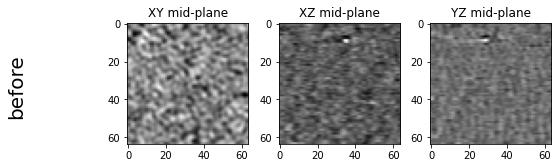

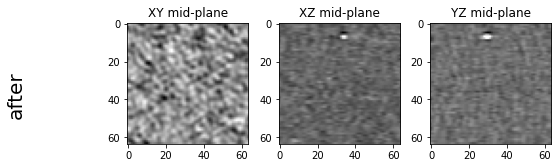

In [13]:
ife = 0
sel_type = "lowest"
p_sel = p.select_by_feature(10, ife = ife, selection_by = sel_type)
for ii in range(10):
    show_before_after(vols, p_sel, ii)

**with pixel-mse**

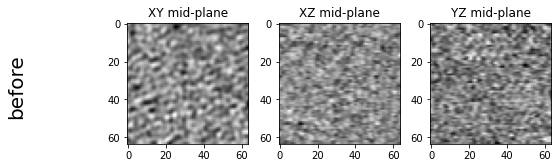

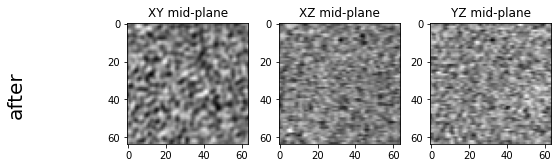

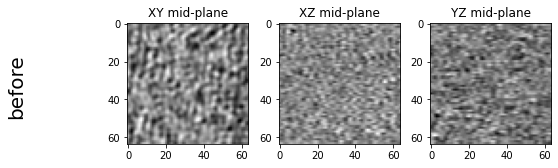

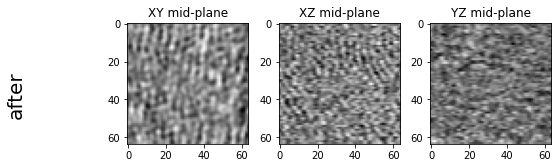

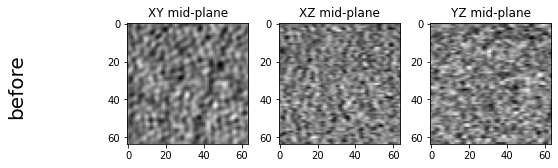

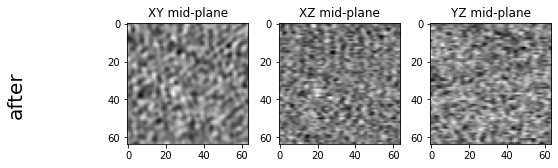

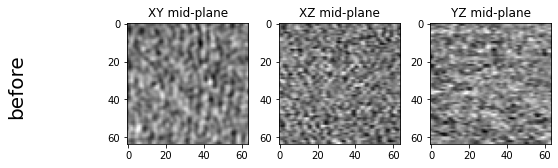

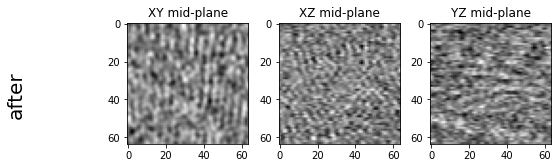

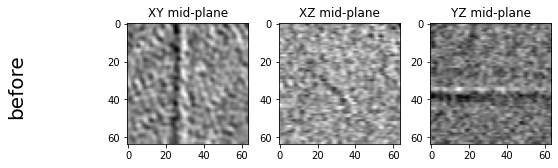

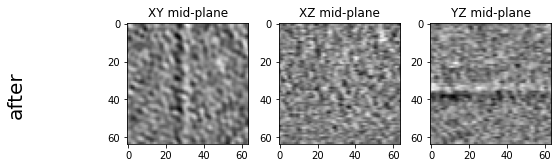

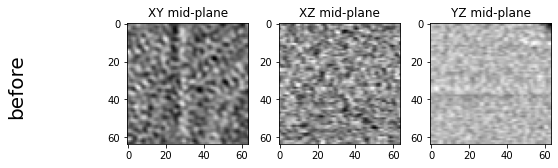

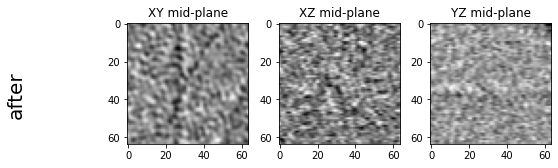

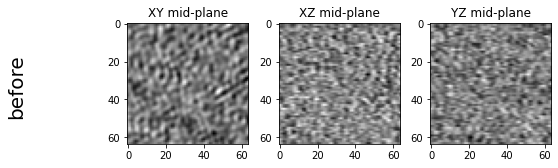

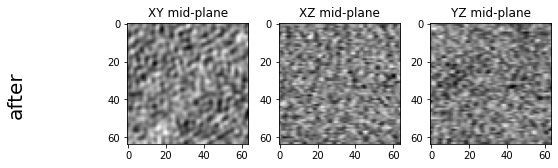

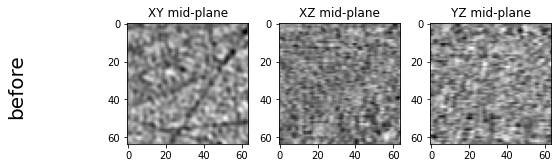

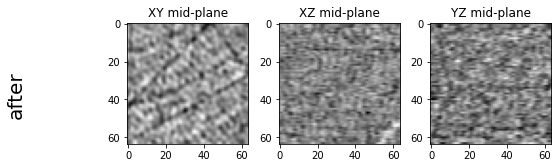

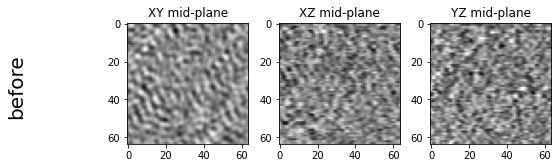

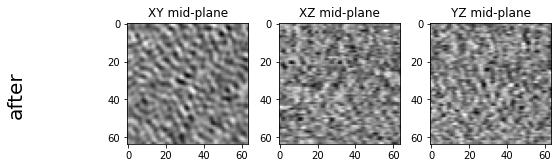

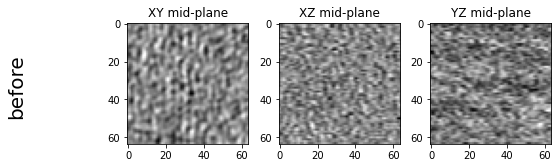

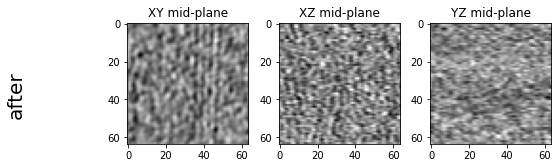

In [14]:
ife = 1
sel_type = "lowest"
p_sel = p.select_by_feature(10, ife = ife, selection_by = sel_type)
for ii in range(10):
    show_before_after(vols, p_sel, ii)

### Visualize the change as a point cloud  
Yellow indicates higher values, dark purple are low values.  

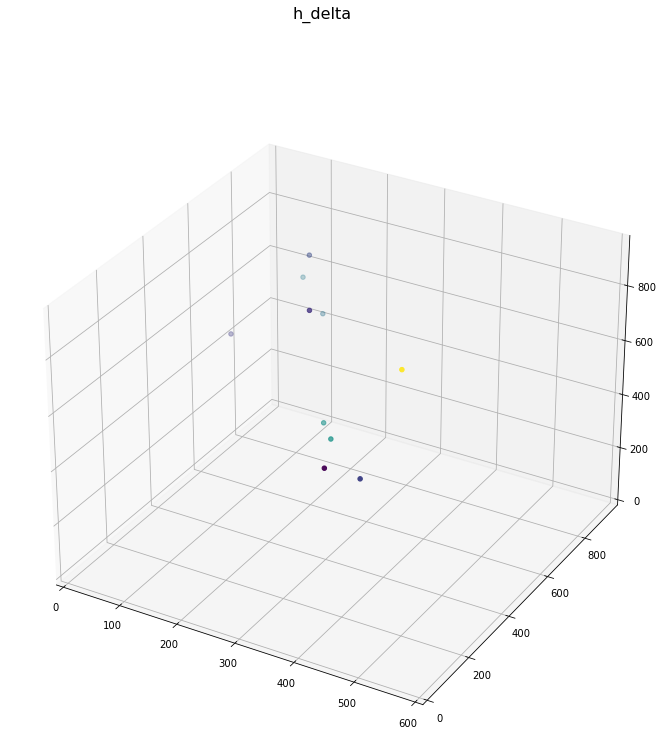

In [15]:
max_pts = 10
ife = 0
p_sel = p.select_by_feature(max_pts, ife = ife, selection_by = "highest")
fig = plt.figure(figsize = (12,12))
p_sel.plot_3D_feature(ife,fig)

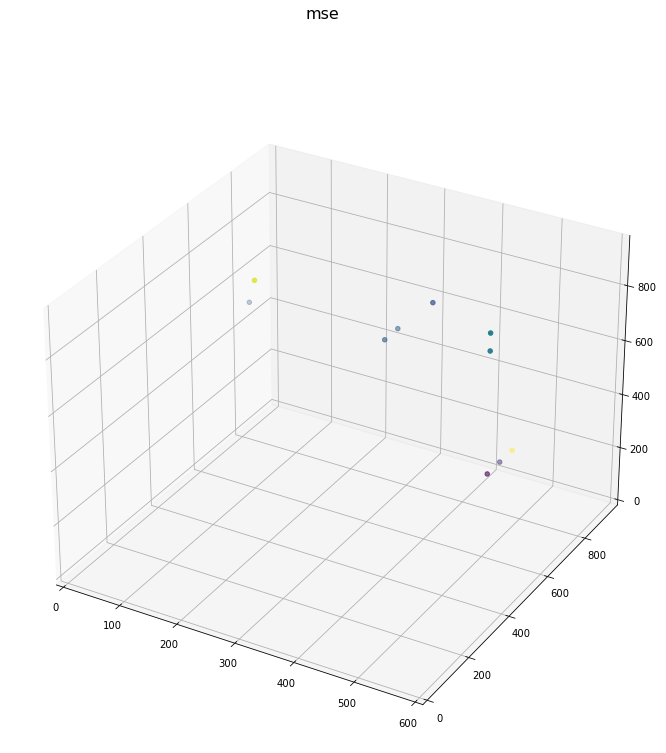

In [16]:
max_pts = 10
ife = 1
p_sel = p.select_by_feature(max_pts, ife = ife, selection_by = "highest")
fig = plt.figure(figsize = (12,12))
p_sel.plot_3D_feature(ife,fig)

### Visualize the change inside big volume  

In [17]:
p_sel.slices()[0][0]

slice(472, 536, 1)

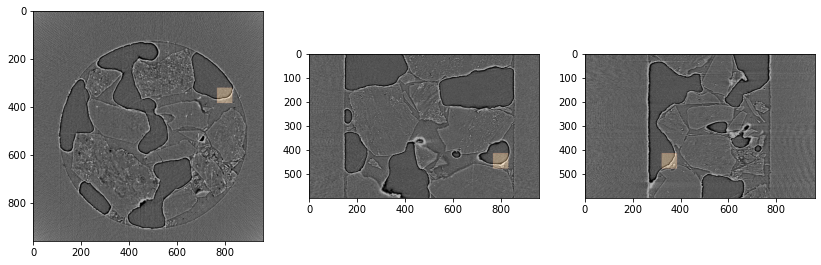

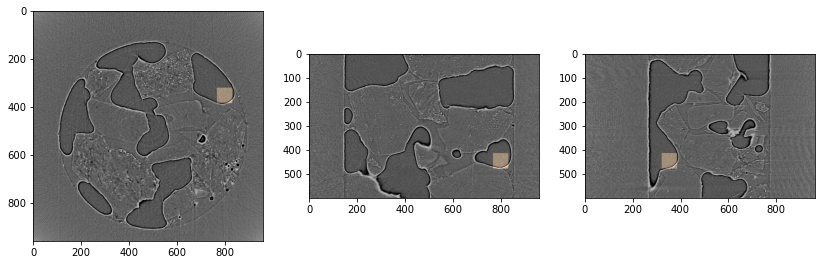

In [18]:
p_sel = p.select_by_feature(max_pts, ife = 0, selection_by = "highest")
show_in_volume(vols, p_sel, 0)